# Neural Collaborative Filtering을 활용한 상품 추천 모델링

참고 [출처](https://arxiv.org/abs/1708.05031)
- Xianan He et al., Neural Collaborative Filtering, WWW 2017.

In [1]:
import pandas as pd
import numpy as np
from glob import glob
import os
import tqdm
# from datasets import load_dataset, Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import pytorch_lightning as pl
from typing import List, Optional, Tuple, Union
import argparse
from sklearn.model_selection import train_test_split

In [2]:
#@title 마이너 패키지 로딩
%matplotlib inline
from datetime import datetime
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

# 설정값

In [3]:
parser = argparse.ArgumentParser()
parser.add_argument("--lr", 
	type=float, 
	default=0.001, 
	help="learning rate")
parser.add_argument("--dropout", 
	type=float,
	default=0.3,  
	help="dropout rate")
parser.add_argument("--batch_size", 
	type=int, 
	default=2048, 
	help="batch size for training")
parser.add_argument("--epochs", 
	type=int,
	default=20,  
	help="training epoches")
parser.add_argument("--top_k", 
	type=int, 
	default=10, 
	help="compute metrics@top_k")
parser.add_argument("--factor_num", 
	type=int,
	default=32, 
	help="predictive factors numbers in the model")
parser.add_argument("--num_ng", 
	type=int,
	default=3, 
	help="sample negative items for training")
parser.add_argument("--test_num_ng", 
	type=int,
	default=49, 
	help="sample part of negative items for testing")
parser.add_argument("--out", 
	default=True,
	help="save model or not")
args = parser.parse_args(args=[])

# 데이터 로더

## 데이터 로딩

사용자 `df_np_item` 셋 컬럼 설명
- 0 ~ 59: one-hot encoding vector
    - `clac_hlv_nm` 대분류를 one-hot encoding ('가구' ~ '화장품/뷰티케어')
- 60 ~ 65: continuous vector
    - 상품이 각 유통사를 통해 구매된 횟수를 유통사별로 랭크화 ('A01_rank' ~ 'A06_rank')
- 66: 상품 인덱스값 (숫자로 된 간접 번호)

In [4]:
type_dic = {}
type_dic.update( {f'{i}':np.float32 for i in range(66)})
type_dic.update({'66':np.int64})

df_np_item = pd.read_csv('csv_np_item.csv', index_col='pd_c', dtype=type_dic)
# df_np_item.info()

사용자 `df_np_user` 셋 컬럼 설명
- 0 ~ 16: one-hot encoding vector 모음
    - 0 ~ 1: 성별 정보 ('남성', '여성')
    - 2 ~ 7: 연령 정보 ('20대', '30대', '40대', '50대', '60대', '70대')
    - 8 ~ 11: 상반기 고객 세그먼트 구분값 ('기타고객', '우수고객', '일반고객', '최우수고객')
        - 주의: 상반기에 구매가 없던 고객은 제외 하였음
    - 12 ~ 16: 하반기 고객 세그먼트 구분값 ('기타고객', '비활동고객', '우수고객', '일반고객', '최우수고객')
- 17 ~ 46: continuous vector 모음
    - 17 ~ 22: 상품 구매 정보의 각 유통사 이용 랭크 ('pdde_A01_rank' ~ 'pdde_A06_rank')
    - 23 ~ 24: 제휴사 이용 정보의 전체 이용 횟수 랭크, 이용 금액 랭크 ('cop_use_rank', 'cop_buy_rank')
    - 25 ~ 30: 제휴사 이용 정보의 각 제휴사 이용 랭크 ('cop_B01_rank'~ 'cop_E01_rank')
    - 31 ~ 32: 엘페이 이용 정보의 전체 이용 횟수 랭크, 이용 금액 랭크 ('lpay_use_rank', 'lpay_buy_rank')
    - 33 ~ 46: 엘페이 이용 정보의 각 유통/제휴사 이용 랭크 ('lpay_A01_rank' ~ 'lpay_L01_rank')
- 47: 고객 인덱스값 (숫자로 된 간접 번호)

In [5]:
type_dic = {}
type_dic.update( {f'{i}':np.float32 for i in range(47)})
type_dic.update({'47':np.int64})

df_np_user = pd.read_csv('csv_np_user.csv', index_col='cust', dtype=type_dic)
# df_np_user.info()

사용자 `df_cust_pd_c_compact` 셋 컬럼 설명

- cust: 원본 고객 식별자
- pd_c: 원본 상품 식별자
- pd_c_no: 상품 인덱스값 (0부터 시작하는 숫자)
- cust_no: 고객 인덱스값 (0부터 시작하는 숫자)
- label: 고객-상품 구매 여부 (1이면 구매)

상품구매 정보 파일로부터 요약및 가공한 데이터프레임
- 고객-상품 구매가 여러번 이더라도 한건만 등장하게 처리함
    - 중복 배제
    - 추천 알고리즘 적용을 하기 위함
- 미구매 정보는 없음: 데이터셋/데이터로더에서 네거티브 샘플링 필요
    - 하단에 구현

In [6]:
df_cust_pd_c_compact = pd.read_csv('csv_user_item_dic.csv')
df_cust_pd_c_compact['label'] = 1.0
# df_cust_pd_c_compact

### 데이터 분할

다음과 같이 `df_cust_pd_c_compact`를 분할함

- `df_data_train` 학습: 1,162,936
- `df_data_validation` 검증: 290,735
- `df_data_test` 테스트: 161,520

In [7]:
df_data_train_before_split, df_data_test = train_test_split(df_cust_pd_c_compact, test_size=0.1, random_state=0)

In [8]:
df_data_train, df_data_validation = train_test_split(df_data_train_before_split, test_size=0.2, random_state=0)

In [9]:
print(len(df_data_train), len(df_data_validation), len(df_data_test))

1162936 290735 161520


In [10]:
display(df_np_item.head(1))
display(df_np_user.head(1))
display(df_data_train.head(1))

,0,1,2,3,4,5,6,7,8,9,...,57,58,59,60,61,62,63,64,65,66
pd_c,,,,,,,,,,,,,,,,,,,,,
PD0001,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.827212,0.232281,0.000517,0.000517,0.000517,0.623383,0


,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
cust,,,,,,,,,,,,,,,,,,,,,
M000034966,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


,cust,pd_c,pd_c_no,cust_no,label
1549143,M955788240,PD0404,403,23987,1.0


### 네거티브 샘플링 구현을 위한 보조 자료

`df_cust_purchased_pd_set` 

- (고객번호 -> 고객이 구매한 모든 상품 번호의 set)을 담는 데이터프레임
- 네거티브 샘플링시 해당 set을 제외한 상품을 샘플링을 실시함

In [11]:
df_cust_purchased_pd_set = df_cust_pd_c_compact.groupby('cust_no').agg({"pd_c_no": lambda x: set(x.unique())})

## 데이터셋

In [30]:
class NCFData(data.Dataset):
    def __init__(self, df_np_item, df_np_user, df_cust_purchased_pd_set, df_data, num_ng = 0, is_training=False, verbose=False):
        super(NCFData, self).__init__()
        
        self.num_ng = num_ng
        self.is_training = is_training
        
        self.df_np_item = df_np_item.set_index('66')
        self.df_np_user = df_np_user.set_index('47')
        self.df_data = df_data
        self.verbose = verbose
              
        # 모든 상품 번호만 모은 집합
        all_pd_c_no_set = set(self.df_np_item.index)
        
        # 고객마다 네거티브 샘플시 포함시킬 수 있는 후보 상품 번호를 생성
        ss_neg_candidates = df_cust_purchased_pd_set.pd_c_no.apply(lambda x: np.array(list(all_pd_c_no_set.difference(x)))).rename('ng_candidates')
        self.xx = pd.merge(self.df_data[['cust_no']], ss_neg_candidates, right_index=True, on='cust_no', how='left')
        
        # item, user 컬럼 범위 정보
        self.item_cols_hlv = self.df_np_item.columns[0:60]
        self.item_cols_RNKs = self.df_np_item.columns[60:66]

        self.user_cols_DEMO = self.df_np_user.columns[0:8]
        self.user_cols_RFMs = self.df_np_user.columns[8:17]
        self.user_cols_RNKs = self.df_np_user.columns[17:47]
        
        if not self.is_training:
            self.ng_sample()
        
    def ng_sample(self):
        '''
            네거티브 샘플링 수행 함수
            Trainer에서 매 학습 에포크 시작시 콜백을 통해 호출됨.
            
            절차
            - 고객의 구매 상품 한 건당 네거티브 샘플 self.num_ng를 샘플링하여 추가
            -- 이유: 상품구매정보는 포지티브 피드백으로 간주되는데, 네거티브 피드백이 없다.
            -- 따라서 네거티브 샘플링 전략을 사용하는 것임
            - 고객마다 구매한 적이 없는 후보 셋을 모아둔 후, 이로부터 self.num_ng 만큼 네거티브 샘플링
            - 이를 포지티브 샘플들과 연결하여 self.samples 구성
        '''
        if self.verbose:
            print('...reorganizing dataset with different negative_samples...')
        
        df_pos = self.df_data[['cust_no', 'pd_c_no', 'label']]
        
        df_neg =  pd.DataFrame({'cust_no': np.concatenate(self.xx.cust_no.apply(lambda x: [x]*self.num_ng).values), 
                      'pd_c_no':np.concatenate(self.xx.ng_candidates.apply(lambda x: np.random.choice(x, self.num_ng)).values)})
        df_neg['label'] = 0.0
        
        self.samples = pd.concat((df_pos, df_neg), ignore_index=True)
    
    def __len__(self):
        return (self.num_ng+1)*len(self.df_data)
    
    def __getitem__(self, idx):
        cust_no = self.samples.cust_no[idx]
        pd_c_no = self.samples.pd_c_no[idx]
        x = self.samples.iloc[idx]
        return {'cust_no':cust_no, 
                'pd_c_no':pd_c_no, 
                'label':x.label, 
                'cust_demo':self.df_np_user.loc[x.pd_c_no][self.user_cols_DEMO].values,
                'cust_rfms':self.df_np_user.loc[x.pd_c_no][self.user_cols_RFMs].values,
                'cust_rnks':self.df_np_user.loc[x.pd_c_no][self.user_cols_RNKs].values,                
                'prod_hlv':self.df_np_item.loc[x.pd_c_no][self.item_cols_hlv].values, 
                'prod_rnks':self.df_np_item.loc[x.pd_c_no][self.item_cols_RNKs].values
               }

### 데이터셋 인스턴스

- `ds_train` 학습 데이터셋
    - 하나의 포지티브 샘플마다 네거티브 샘플의 수 args.num_ng
- `ds_validation` 검증 데이터셋
    - 하나의 포지티브 샘플마다 네거티브 샘플의 수 args.num_ng
- `ds_test` 테스트 데이터셋
    - 최종 테스트 시에는 네거티브 샘플의 수를 args.test_num_ng 로 설정 

In [13]:
ds_train = NCFData(df_np_item, df_np_user, df_cust_purchased_pd_set, df_data_train, num_ng=args.num_ng, is_training=True, verbose=True)

ds_validation = NCFData(df_np_item, df_np_user, df_cust_purchased_pd_set, df_data_validation[:50000], num_ng=args.num_ng, is_training=False, verbose=True)

ds_test = NCFData(df_np_item, df_np_user, df_cust_purchased_pd_set, df_data_test, num_ng=args.test_num_ng, is_training=False, verbose=True)

...reorganizing dataset with different negative_samples...
...reorganizing dataset with different negative_samples...


# 라이트닝 모듈

## 모델

In [14]:
class GMF(torch.nn.Module):
    '''
    사용자 임베딩 벡터 (embed_user) 와 사용자 컨텐트 벡터 (content_uer) 를 cat 하고,
    Linear 레이어를 통과 시켜 사이즈를 조절, 
    아이템 임베딩 벡터 (embed_item)과 element-wise 곱 수행하여 출력
    '''
    def __init__(self, factor_num, content_len):
        super().__init__()
        self.GMF_layers = nn.Sequential(nn.Linear(factor_num+content_len, factor_num),)
        
    def forward(self, embed_user, embed_item, content_user):
        in_user = torch.cat((embed_user, content_user), dim=-1)
        out_user = self.GMF_layers(in_user)
        return out_user * embed_item   

In [15]:
class MLP_extended(torch.nn.Module):
    '''
    '''
    def __init__(self, factor_num, user_content_len, item_content_len, dropout):
        super().__init__()
        MLP_modules = []
        
        layer_configuration = [factor_num*2 + user_content_len + item_content_len, 128, 64, 32]
        for i in range(len(layer_configuration)-1):
            input_size, output_size = layer_configuration[i], layer_configuration[i+1]
            MLP_modules.append(nn.Dropout(p=dropout))
            MLP_modules.append(nn.Linear(input_size, output_size))
            MLP_modules.append(nn.ReLU())
        self.MLP_layers = nn.Sequential(*MLP_modules)

    def forward(self, embed_user, embed_item, content_user, content_item):
#         print(embed_user.shape, embed_item.shape, content_user.shape, content_item.shape)
        interaction = torch.cat((embed_user, embed_item, content_user, content_item), dim=-1)
        return self.MLP_layers(interaction)    

In [16]:
class NCF(pl.LightningModule):
    def __init__(self, user_num, item_num, factor_num, dropout):
        super().__init__()
        self.user_num = user_num
        self.item_num = item_num
        self.factor_num = factor_num
        self.dropout = dropout
        self.cust_demo_len = 8
        self.cust_rfms_len = 9
        self.cust_rnks_len = 30
        self.prod_hlv_len = 60
        self.prod_rnks = 6
        
        self.save_hyperparameters()
        
        self.embed_user_GMF = nn.Embedding(self.user_num, self.factor_num)
        self.embed_item_GMF = nn.Embedding(self.item_num, self.factor_num)
        self.embed_user_MLP = nn.Embedding(self.user_num, self.factor_num)
        self.embed_item_MLP = nn.Embedding(self.item_num, self.factor_num)
        
        self.GMF = GMF(self.factor_num, self.cust_rfms_len)
        self.MLP = MLP_extended(self.factor_num, 
                                self.cust_demo_len + self.cust_rfms_len +self.cust_rnks_len, 
                                self.prod_hlv_len + self.prod_rnks, 
                                self.dropout)
        
        predict_size = factor_num * 2
        self.predict_layer = nn.Linear(predict_size, 1)
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer
    
    def forward(self, batch):
        user, item = batch['cust_no'], batch['pd_c_no']
        
        embed_user_GMF = self.embed_user_GMF(user)
        embed_item_GMF = self.embed_item_GMF(item)
        
        output_GMF = self.GMF(embed_user_GMF, embed_item_GMF, batch['cust_rfms'])

        embed_user_MLP = self.embed_user_MLP(user)
        embed_item_MLP = self.embed_item_MLP(item)
        
        content_user = torch.cat((batch['cust_demo'], batch['cust_rfms'], batch['cust_rnks']), -1)
        content_item = torch.cat((batch['prod_hlv'], batch['prod_rnks']), -1)
        output_MLP = self.MLP(embed_user_MLP, embed_item_MLP, content_user, content_item)

        concat = torch.cat((output_GMF, output_MLP), -1)
        prediction = self.predict_layer(concat)

        return prediction.view(-1)
    
    def training_step(self, batch, batch_index):
        prediction = self.forward(batch)
        
        bce_loss = F.binary_cross_entropy_with_logits(prediction, batch['label'])
        self.log("bce_loss", bce_loss, prog_bar=False, logger=True, on_step=True, on_epoch=False)
        
        return bce_loss
    
    def validation_step(self, batch, batch_index):
        prediction = self.forward(batch)
        bce_loss = F.binary_cross_entropy_with_logits(prediction, batch['label'])
        self.log("val_bce_loss", bce_loss, prog_bar=True, logger=True, on_step=False, on_epoch=True)
        
        return bce_loss
    
    def predict_step(self, batch, batch_index):
        prediction = self.forward(batch)
        
        return {'pred':prediction, 'true':batch['label'], 'cust_no': batch['cust_no'], 'prod_no':batch['pd_c_no']}

In [17]:
class CallbackGenerateNegSamples(pl.Callback):
    def __init__(self, verbose=True):
        self.verbose = verbose

    def on_train_epoch_start(self, trainer, dummy):
        '''
        학습 에포크 시작시 원본 dataset의 네거티브 샘플 생성 함수인 `ng_sample()`을 호출
        '''
        if self.verbose:
            print('... callback: on_train_epoch_start...')
            trainer.train_dataloader.loaders.dataset.ng_sample()          

### 모델 아키텍쳐

In [18]:
model = NCF(user_num=len(df_np_user), item_num=len(df_np_item), factor_num=args.factor_num, dropout=args.dropout)

In [19]:
model

NCF(
  (embed_user_GMF): Embedding(25035, 32)
  (embed_item_GMF): Embedding(1933, 32)
  (embed_user_MLP): Embedding(25035, 32)
  (embed_item_MLP): Embedding(1933, 32)
  (GMF): GMF(
    (GMF_layers): Sequential(
      (0): Linear(in_features=41, out_features=32, bias=True)
    )
  )
  (MLP): MLP_extended(
    (MLP_layers): Sequential(
      (0): Dropout(p=0.3, inplace=False)
      (1): Linear(in_features=177, out_features=128, bias=True)
      (2): ReLU()
      (3): Dropout(p=0.3, inplace=False)
      (4): Linear(in_features=128, out_features=64, bias=True)
      (5): ReLU()
      (6): Dropout(p=0.3, inplace=False)
      (7): Linear(in_features=64, out_features=32, bias=True)
      (8): ReLU()
    )
  )
  (predict_layer): Linear(in_features=64, out_features=1, bias=True)
)

### 트레이너 설정

In [20]:
ckpt_path = os.path.abspath('learning_results_ncf_entire_data')

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath=ckpt_path,
    save_top_k=2,
    monitor='val_bce_loss',
    mode='min',
    filename='{epoch}-{val_bce_loss:.4f}',
)

trainer = pl.Trainer(default_root_dir=ckpt_path,
#                      fast_dev_run=7,
                     max_epochs=args.epochs,
                     accelerator="gpu",
                     devices=1,
                     callbacks=[CallbackGenerateNegSamples(), checkpoint_callback]
                     )

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [21]:
train_dataloader = data.DataLoader(ds_train, batch_size=args.batch_size, shuffle=True, num_workers=16)
validation_dataloader = data.DataLoader(ds_validation, batch_size=args.batch_size, shuffle=False, num_workers=8)

## 학습

### 텐서보드

In [22]:
# Start tensorboard.
%reload_ext tensorboard
%tensorboard --logdir=learning_results_ncf_entire_data --host 0.0.0.0 --port=6007

### 학습 (fit)

In [23]:
trainer.fit(model=model, train_dataloaders=train_dataloader, val_dataloaders = validation_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name           | Type         | Params
------------------------------------------------
0 | embed_user_GMF | Embedding    | 801 K 
1 | embed_item_GMF | Embedding    | 61.9 K
2 | embed_user_MLP | Embedding    | 801 K 
3 | embed_item_MLP | Embedding    | 61.9 K
4 | GMF            | GMF          | 1.3 K 
5 | MLP            | MLP_extended | 33.1 K
6 | predict_layer  | Linear       | 65    
------------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.042     Total estimated model params size (MB)
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /Jupyter/LotteCompetition_2022/learning_results_ncf_entire_data exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

... callback: on_train_epoch_start...
...reorganizing dataset with different negative_samples...


Validating: 0it [00:00, ?it/s]

... callback: on_train_epoch_start...
...reorganizing dataset with different negative_samples...


Validating: 0it [00:00, ?it/s]

... callback: on_train_epoch_start...
...reorganizing dataset with different negative_samples...


Validating: 0it [00:00, ?it/s]

... callback: on_train_epoch_start...
...reorganizing dataset with different negative_samples...


Validating: 0it [00:00, ?it/s]

... callback: on_train_epoch_start...
...reorganizing dataset with different negative_samples...


Validating: 0it [00:00, ?it/s]

... callback: on_train_epoch_start...
...reorganizing dataset with different negative_samples...


Validating: 0it [00:00, ?it/s]

... callback: on_train_epoch_start...
...reorganizing dataset with different negative_samples...


Validating: 0it [00:00, ?it/s]

... callback: on_train_epoch_start...
...reorganizing dataset with different negative_samples...


Validating: 0it [00:00, ?it/s]

... callback: on_train_epoch_start...
...reorganizing dataset with different negative_samples...


Validating: 0it [00:00, ?it/s]

... callback: on_train_epoch_start...
...reorganizing dataset with different negative_samples...


Validating: 0it [00:00, ?it/s]

... callback: on_train_epoch_start...
...reorganizing dataset with different negative_samples...


Validating: 0it [00:00, ?it/s]

... callback: on_train_epoch_start...
...reorganizing dataset with different negative_samples...


Validating: 0it [00:00, ?it/s]

... callback: on_train_epoch_start...
...reorganizing dataset with different negative_samples...


Validating: 0it [00:00, ?it/s]

... callback: on_train_epoch_start...
...reorganizing dataset with different negative_samples...


Validating: 0it [00:00, ?it/s]

... callback: on_train_epoch_start...
...reorganizing dataset with different negative_samples...


Validating: 0it [00:00, ?it/s]

... callback: on_train_epoch_start...
...reorganizing dataset with different negative_samples...


Validating: 0it [00:00, ?it/s]

... callback: on_train_epoch_start...
...reorganizing dataset with different negative_samples...


Validating: 0it [00:00, ?it/s]

... callback: on_train_epoch_start...
...reorganizing dataset with different negative_samples...


Validating: 0it [00:00, ?it/s]

... callback: on_train_epoch_start...
...reorganizing dataset with different negative_samples...


Validating: 0it [00:00, ?it/s]

... callback: on_train_epoch_start...
...reorganizing dataset with different negative_samples...


Validating: 0it [00:00, ?it/s]

## 예측 결과 분석

베스트 모델 체크포인트: `learning_results_ncf_entire_data/epoch=19-val_bce_loss=0.3256.ckpt`

필요시 이를 재로딩 하자

In [24]:
test_dataloader = data.DataLoader(ds_test, batch_size=args.batch_size, shuffle=False, num_workers=16)

In [25]:
predict_results = trainer.predict(dataloaders=test_dataloader)

/usr/local/lib/python3.6/dist-packages/pytorch_lightning/trainer/trainer.py:1399: UserWarning: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `predict(ckpt_path='best')` to use and best model checkpoint and avoid this warning or `ckpt_path=trainer.checkpoint_callback.last_model_path` to use the last model.
  f"`.{fn}(ckpt_path=None)` was called without a model."
Restoring states from the checkpoint path at /Jupyter/LotteCompetition_2022/learning_results_ncf_entire_data/epoch=19-val_bce_loss=0.3256.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]
Loaded model weights from checkpoint at /Jupyter/LotteCompetition_2022/learning_results_ncf_entire_data/epoch=19-val_bce_loss=0.3256.ckpt


Predicting: 2272it [00:00, ?it/s]

In [26]:
def calc_hit_top_k(ss, k=2, ng_num=3):
    '''
        고객마다 
        - 포지티브 레이블 (1.0)에 해당하는 케이스마다 ng_num 개의 네거티브 케이스 (0.0) 들을 포함하므로...
        - (ng_num+1 개의 예측에 대해) 예측값 상위 top_k에 포지티브 레이블이 위치 하면 hit로 계산
        - 즉 1을 출력, 그렇지 않으면 0을 출력
        - (고객의 포지티브-네거티브 구성이 2개 이상 포함될 수 있으므로 그런 경우는 동적으로 조정하여 계산)
    '''
    n_true_cases = len(ss) // (ng_num+1)
    n = n_true_cases * k
    return 0 if ss.sort_values(by='pred', ascending=False)[:n]['true'].sum() < n_true_cases else 1

In [27]:
dic = {k:[] for k in predict_results[0].keys()}

for result in predict_results:
    for k in dic.keys():
        dic[k].append(result[k])

final_dic = {k:torch.cat(dic[k]).numpy()  for k in dic.keys()}
    

df_predict = pd.DataFrame(final_dic)

df_predicted_merged = pd.merge(
    pd.merge(df_predict, df_np_item['66'].rename('prod_no').reset_index(), on='prod_no'),
    df_np_user['47'].rename('cust_no').reset_index(), on='cust_no'
)

In [28]:
test_dic = {}
for k in range(1, 10):
    hit_ratios = df_predicted_merged.groupby('cust').apply(lambda x: calc_hit_top_k(x[['pred', 'true']], k=k, ng_num=args.test_num_ng)).value_counts(normalize=True)
    test_dic[k] = hit_ratios.sort_index()

In [44]:
df_predicted_merged.to_csv("csv_prediction_for_test_ng49.csv")

In [45]:
df_predicted_merged.head()

,pred,true,cust_no,prod_no,pd_c,cust
0,-0.104241,1.0,20763,501,PD0502,M825964298
1,1.273770,0.0,20763,1416,PD1417,M825964298
2,-0.503362,0.0,20763,1676,PD1677,M825964298
3,-0.170538,0.0,20763,1852,PD1853,M825964298
4,-0.170538,0.0,20763,1852,PD1853,M825964298


### Top-k에 따른 HitRatio (HR)

In [41]:
hit_ratio_dic = {k:info.iloc[1] for k, info in test_dic.items()}

df_hit_ratio = pd.DataFrame.from_dict(hit_ratio_dic, orient='index', columns=['HR']).rename_axis('k')

df_hit_ratio

,HR
k,
1,0.045123
2,0.087498
3,0.132164
4,0.171194
5,0.212378
6,0.252920
7,0.289706
8,0.327638
9,0.367584


<AxesSubplot:xlabel='k'>

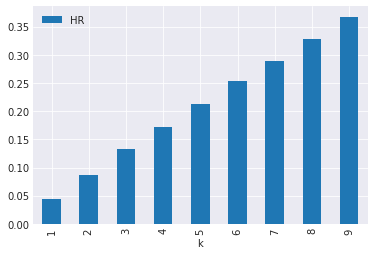

In [42]:
df_hit_ratio.plot.bar()